# Opis podjętych problemów

1. Rozmiar zbioru testowego i treningowego
2. Rodzaj funkcji aktywacji
3. Liczba neuronów
4. Metoda uczenia

# Przegląd literatury

 - https://prac.im.pwr.edu.pl/~zak/Pawel_Gburzynski_Sztuczna_inteligencja_cz_3_Sieci_neuronowe.pdf <br>
 - https://gdudek.el.pcz.pl/files/SI/SI_wyklad6.pdf

## Biblioteki

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

## Dane

In [2]:
weather = pd.read_csv("klasyfikacja/weather_classification_data.csv")
weather.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


## Opis danych

### Zmienne numeryczne:
- **Temperatura (°C)** – temperatura w stopniach Celsjusza; obejmuje wartości od bardzo niskich (ekstremalne zimno) do bardzo wysokich (ekstremalne upały).
- **Wilgotność (%)** – procentowa wilgotność powietrza; zawiera również wartości powyżej 100%, co wskazuje na obecność wartości odstających (outliers).
- **Prędkość wiatru (km/h)** – prędkość wiatru w kilometrach na godzinę; obejmuje również nierealistycznie wysokie wartości jako potencjalne wartości odstające.
- **Opady (%)** – procent opadów; zawiera nietypowe wartości, które mogą wskazywać na błędy pomiarowe lub ekstremalne zjawiska pogodowe.
- **Ciśnienie atmosferyczne (hPa)** – ciśnienie atmosferyczne w hektopaskalach; szeroki zakres wartości.
- **Indeks UV** – wartość indeksu UV, określająca natężenie promieniowania ultrafioletowego.
- **Widoczność (km)** – widoczność w kilometrach; obejmuje bardzo niskie oraz bardzo wysokie wartości.

### Zmienne kategoryczne:
- **Zachmurzenie** – opis stopnia zachmurzenia nieba (np. brak chmur, częściowe zachmurzenie, całkowite zachmurzenie).
- **Pora roku** – pora roku, w której zarejestrowano dane (np. wiosna, lato, jesień, zima).
- **Lokalizacja** – typ miejsca, w którym dokonano pomiaru (np. obszar miejski, wiejski, górski).
- **Typ pogody (zmienna docelowa)** – klasyfikacja typu pogody (np. słonecznie, deszczowo, burzowo, śnieżnie).

In [3]:
categorical_cols = ['Cloud Cover', 'Season', 'Location']
label_encoders = {}

numeric_cols = [
    'Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
    'Atmospheric Pressure', 'UV Index', 'Visibility (km)'
]


Macierz korelacji

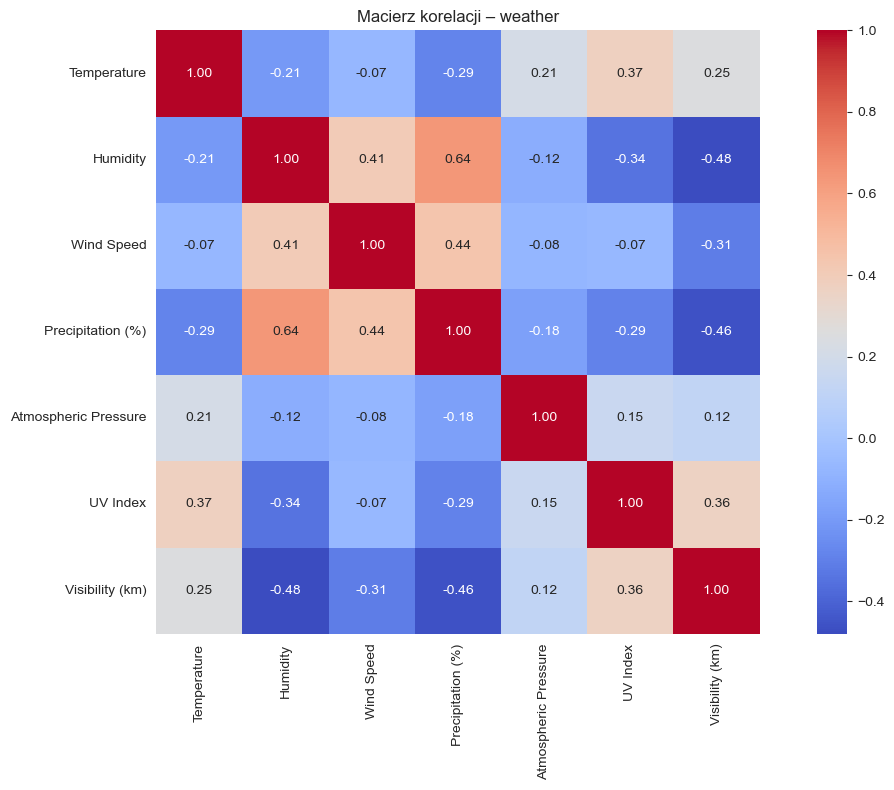

In [4]:
corr_matrix = weather[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Macierz korelacji – weather")
plt.tight_layout()
plt.show()

Rozkład Y

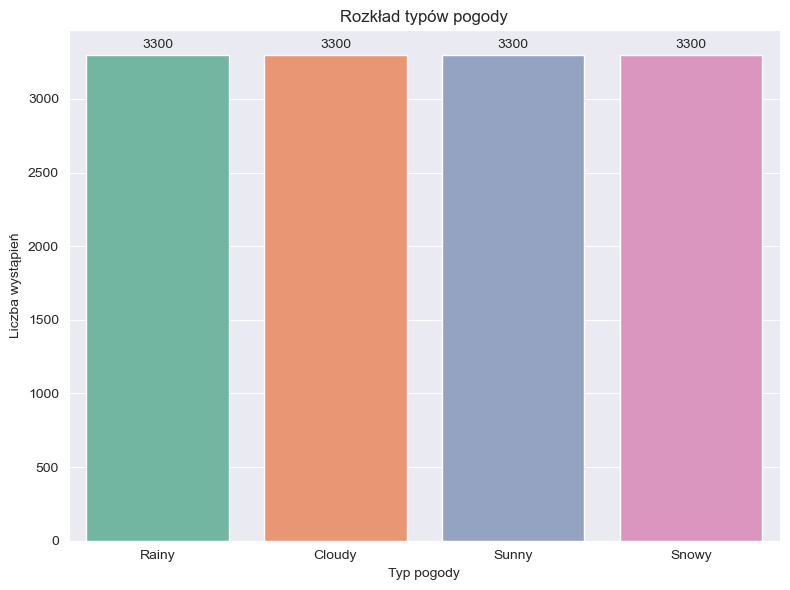

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=weather, x='Weather Type', hue='Weather Type', palette='Set2', legend=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.title("Rozkład typów pogody")
plt.xlabel("Typ pogody")
plt.ylabel("Liczba wystąpień")
plt.tight_layout()
plt.show()

In [6]:
for col in categorical_cols:
    le = LabelEncoder()
    weather[col] = le.fit_transform(weather[col])
    label_encoders[col] = le

Usuwanie wartości odstających

In [7]:
def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = cleaned_df.shape[0]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
        after = cleaned_df.shape[0]
        print(f"Removed {before - after} outliers from '{col}'")
    return cleaned_df


cleaned_df = remove_outliers_iqr(weather, numeric_cols)

Removed 92 outliers from 'Temperature'
Removed 0 outliers from 'Humidity'
Removed 396 outliers from 'Wind Speed'
Removed 0 outliers from 'Precipitation (%)'
Removed 927 outliers from 'Atmospheric Pressure'
Removed 112 outliers from 'UV Index'
Removed 87 outliers from 'Visibility (km)'


Podział na zbiór treningowy i testowy

In [8]:
X = cleaned_df.drop("Weather Type", axis=1)
y = cleaned_df["Weather Type"]

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values



## Budowa sieci neuronowej

In [9]:
class SimpleNN:
    def __init__(self, input_size, hidden_size=64, output_size=4, learning_rate=0.001, epochs=10000, random_state=0):
        np.random.seed(random_state)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs


        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def cross_entropy(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m
        return loss

    def to_one_hot(self, y):
        one_hot = np.zeros((y.size, self.output_size))
        one_hot[np.arange(y.size), y] = 1
        return one_hot

    def fit(self, X_train, y_train, verbose=False):
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        y_train_one_hot = self.to_one_hot(y_train)

        for epoch in range(self.epochs):

            z1 = X_train @ self.W1 + self.b1
            a1 = self.relu(z1)
            z2 = a1 @ self.W2 + self.b2
            a2 = self.softmax(z2)


            loss = self.cross_entropy(y_train_one_hot, a2)


            dz2 = a2 - y_train_one_hot
            dW2 = a1.T @ dz2 / X_train.shape[0]
            db2 = np.sum(dz2, axis=0, keepdims=True) / X_train.shape[0]

            dz1 = dz2 @ self.W2.T * self.relu_derivative(z1)
            dW1 = X_train.T @ dz1 / X_train.shape[0]
            db1 = np.sum(dz1, axis=0, keepdims=True) / X_train.shape[0]


            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2

            if verbose and (epoch % 500 == 0 or epoch == self.epochs - 1):
                print(f"Epoch {epoch} — Loss: {loss:.4f}")

    def predict(self, X):
        X = np.array(X)
        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = self.softmax(z2)
        return np.argmax(a2, axis=1)

    @staticmethod
    def encode_labels(y):
        le = LabelEncoder()
        return le.fit_transform(y), le
    
def train_batch_gradient_descent(X_train, y_train_encoded, X_test, y_test_encoded, input_size, output_size):
    model = SimpleNN(input_size=input_size, output_size=output_size, epochs=10000)
    model.fit(X_train, y_train_encoded, verbose=True)
    return model

def train_on_batch(self, X_batch, y_batch):
    X_batch = np.array(X_batch)
    y_batch = np.array(y_batch)
    y_one_hot = self.to_one_hot(y_batch)

    z1 = X_batch @ self.W1 + self.b1
    a1 = self.relu(z1)
    z2 = a1 @ self.W2 + self.b2
    a2 = self.softmax(z2)

    loss = self.cross_entropy(y_one_hot, a2)

    dz2 = a2 - y_one_hot
    dW2 = a1.T @ dz2 / X_batch.shape[0]
    db2 = np.sum(dz2, axis=0, keepdims=True) / X_batch.shape[0]

    dz1 = dz2 @ self.W2.T * self.relu_derivative(z1)
    dW1 = X_batch.T @ dz1 / X_batch.shape[0]
    db1 = np.sum(dz1, axis=0, keepdims=True) / X_batch.shape[0]

    self.W1 -= self.learning_rate * dW1
    self.b1 -= self.learning_rate * db1
    self.W2 -= self.learning_rate * dW2
    self.b2 -= self.learning_rate * db2

    return loss


def train_mini_batch_gradient_descent(X_train, y_train_encoded, X_test, y_test_encoded, input_size, output_size, batch_size=32):
    model = SimpleNN(input_size=input_size, output_size=output_size, epochs=10000)
    import types
    model.train_on_batch = types.MethodType(train_on_batch, model)  

    epochs = 10000
    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train_encoded[indices]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            loss = model.train_on_batch(X_batch, y_batch)

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} — Loss: {loss:.4f}")

    return model

def train_momentum(X_train, y_train_encoded, X_test, y_test_encoded, input_size, output_size,
                   learning_rate=0.001, momentum=0.9, epochs=10000, batch_size=32):
    model = SimpleNN(input_size=input_size, output_size=output_size, epochs=1, learning_rate=learning_rate)

    import types
    model.train_on_batch = types.MethodType(train_on_batch, model)

    v_W1 = np.zeros_like(model.W1)
    v_b1 = np.zeros_like(model.b1)
    v_W2 = np.zeros_like(model.W2)
    v_b2 = np.zeros_like(model.b2)

    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train_encoded[indices]

        total_loss = 0
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            y_one_hot = model.to_one_hot(y_batch)

            z1 = X_batch @ model.W1 + model.b1
            a1 = model.relu(z1)
            z2 = a1 @ model.W2 + model.b2
            a2 = model.softmax(z2)

            dz2 = a2 - y_one_hot
            dW2 = a1.T @ dz2 / batch_size
            db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size

            dz1 = dz2 @ model.W2.T * model.relu_derivative(z1)
            dW1 = X_batch.T @ dz1 / batch_size
            db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size

            v_W1 = momentum * v_W1 - learning_rate * dW1
            model.W1 += v_W1

            v_b1 = momentum * v_b1 - learning_rate * db1
            model.b1 += v_b1

            v_W2 = momentum * v_W2 - learning_rate * dW2
            model.W2 += v_W2

            v_b2 = momentum * v_b2 - learning_rate * db2
            model.b2 += v_b2

            total_loss += model.cross_entropy(y_one_hot, a2)

        if epoch % 500 == 0 or epoch == epochs - 1:
            avg_loss = total_loss / (X_train.shape[0] // batch_size)
            print(f"Epoch {epoch} — Loss: {avg_loss:.4f}")

    return model

def train_adagrad(X_train, y_train_encoded, X_test, y_test_encoded, input_size, output_size,
                  learning_rate=0.001, epsilon=1e-8, epochs=10000, batch_size=32):
    model = SimpleNN(input_size=input_size, output_size=output_size, epochs=1, learning_rate=learning_rate)

    import types
    model.train_on_batch = types.MethodType(train_on_batch, model)

    G_W1 = np.zeros_like(model.W1)
    G_b1 = np.zeros_like(model.b1)
    G_W2 = np.zeros_like(model.W2)
    G_b2 = np.zeros_like(model.b2)

    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train_encoded[indices]

        total_loss = 0
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            y_one_hot = model.to_one_hot(y_batch)

            z1 = X_batch @ model.W1 + model.b1
            a1 = model.relu(z1)
            z2 = a1 @ model.W2 + model.b2
            a2 = model.softmax(z2)

            dz2 = a2 - y_one_hot
            dW2 = a1.T @ dz2 / batch_size
            db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size

            dz1 = dz2 @ model.W2.T * model.relu_derivative(z1)
            dW1 = X_batch.T @ dz1 / batch_size
            db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size

            G_W1 += dW1 ** 2
            G_b1 += db1 ** 2
            G_W2 += dW2 ** 2
            G_b2 += db2 ** 2

            model.W1 -= learning_rate * dW1 / (np.sqrt(G_W1) + epsilon)
            model.b1 -= learning_rate * db1 / (np.sqrt(G_b1) + epsilon)
            model.W2 -= learning_rate * dW2 / (np.sqrt(G_W2) + epsilon)
            model.b2 -= learning_rate * db2 / (np.sqrt(G_b2) + epsilon)

            total_loss += model.cross_entropy(y_one_hot, a2)

        if epoch % 500 == 0 or epoch == epochs - 1:
            avg_loss = total_loss / (X_train.shape[0] // batch_size)
            print(f"Epoch {epoch} — Loss: {avg_loss:.4f}")

    return model


Tworzenie i trenowanie modelu

In [10]:
y_train_encoded, label_encoder = SimpleNN.encode_labels(y_train)
y_test_encoded = label_encoder.transform(y_test)

input_size = X_train.shape[1]
output_size = len(np.unique(y))
model = SimpleNN(input_size=input_size, output_size=output_size, epochs=10000, learning_rate=0.001)
model.fit(X_train, y_train_encoded, verbose=True)

Epoch 0 — Loss: 1.8149
Epoch 500 — Loss: 0.6718
Epoch 1000 — Loss: 0.4981
Epoch 1500 — Loss: 0.4242
Epoch 2000 — Loss: 0.3818
Epoch 2500 — Loss: 0.3534
Epoch 3000 — Loss: 0.3327
Epoch 3500 — Loss: 0.3167
Epoch 4000 — Loss: 0.3038
Epoch 4500 — Loss: 0.2930
Epoch 5000 — Loss: 0.2839
Epoch 5500 — Loss: 0.2761
Epoch 6000 — Loss: 0.2692
Epoch 6500 — Loss: 0.2632
Epoch 7000 — Loss: 0.2578
Epoch 7500 — Loss: 0.2529
Epoch 8000 — Loss: 0.2485
Epoch 8500 — Loss: 0.2445
Epoch 9000 — Loss: 0.2408
Epoch 9500 — Loss: 0.2375
Epoch 9999 — Loss: 0.2344


Predykcja na zbiorze testowym

In [11]:
y_pred = model.predict(X_test)

Odwracamy kodowanie etykiet (LabelEncoder) do oryginalnych nazw pogodowych

In [12]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

prawdziwy vs przewidziany typ pogody

In [13]:
print("\nPrzykładowe przewidywanie (rzeczywisty typ vs przewidziany):")
for i in range(min(10, len(y_test))):
    print(f"Rzeczywista: {y_test[i]} \t|\tPrzewidziana: {y_pred_decoded[i]}")


Przykładowe przewidywanie (rzeczywisty typ vs przewidziany):
Rzeczywista: Sunny 	|	Przewidziana: Sunny
Rzeczywista: Sunny 	|	Przewidziana: Sunny
Rzeczywista: Rainy 	|	Przewidziana: Rainy
Rzeczywista: Rainy 	|	Przewidziana: Rainy
Rzeczywista: Snowy 	|	Przewidziana: Snowy
Rzeczywista: Cloudy 	|	Przewidziana: Cloudy
Rzeczywista: Snowy 	|	Przewidziana: Snowy
Rzeczywista: Rainy 	|	Przewidziana: Rainy
Rzeczywista: Cloudy 	|	Przewidziana: Sunny
Rzeczywista: Rainy 	|	Przewidziana: Rainy


In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_decoded)
print(f"Dokładność modelu: {accuracy:.4f}")


Dokładność modelu: 0.9387


# Badania

## Analiza wpływu rozmiaru zbioru testowego i treningowego na działanie sieci

Pobranie zapisanych wartości z excela `results_avg.xlsx`. <br>
Plik z kodem `test_train_klasyfikacja.py`

### Opis problemu i podjętych kroków

W celu analizy działania stworzonej sieci neuronowej zdecydowałem się zbadać wpływ rozmiaru zbiorów treningowego i testowego na skuteczność modelu. Sieć była wielokrotnie trenowana przy różnych podziałach danych, a następnie oceniana za pomocą miar błędu: Accuracy, F1 Score, Recall oraz Precision – zarówno dla zbioru treningowego, jak i testowego.

Analiza została przeprowadza w pliku `test_train_klasyfikacja.py`. Następnie rezultaty zapisane w pliku `results_avg.xlsx` i odczytane w Jupyter. Zostały zwizualizowane i przeanalizowane. Na samym końcu wyciągnąłem wnioski.

In [15]:
plik = 'klasyfikacja/results_avg.xlsx'
xls = pd.ExcelFile(plik)
train_test_df = xls.parse()
train_test_df=train_test_df.round(4)

In [16]:
train_test_df

,test_size,avg_train_accuracy,avg_test_accuracy,avg_precision_train_Cloudy,avg_recall_train_Cloudy,avg_f1_train_Cloudy,avg_precision_test_Cloudy,avg_recall_test_Cloudy,avg_f1_test_Cloudy,avg_precision_train_Rainy,...,avg_f1_train_Snowy,avg_precision_test_Snowy,avg_recall_test_Snowy,avg_f1_test_Snowy,avg_precision_train_Sunny,avg_recall_train_Sunny,avg_f1_train_Sunny,avg_precision_test_Sunny,avg_recall_test_Sunny,avg_f1_test_Sunny
0,0.1,0.6628,0.6559,0.7622,0.6194,0.5941,0.7524,0.5939,0.5685,0.6791,...,0.7071,0.8105,0.7750,0.7060,0.5741,0.7108,0.6339,0.5698,0.7095,0.6300
1,0.2,0.7107,0.7091,0.8618,0.4423,0.5513,0.8485,0.4372,0.5434,0.6580,...,0.8307,0.7686,0.9708,0.8283,0.6806,0.8832,0.7655,0.6805,0.8846,0.7656
2,0.3,0.7227,0.7226,0.8829,0.4619,0.5888,0.8788,0.4649,0.5909,0.6783,...,0.8313,0.7584,0.9757,0.8298,0.6886,0.8924,0.7743,0.6899,0.8923,0.7751
3,0.4,0.7469,0.7481,0.8975,0.4795,0.6013,0.8966,0.4894,0.6114,0.6522,...,0.8545,0.8289,0.9254,0.8489,0.7158,0.8740,0.7835,0.7199,0.8748,0.7863


In [17]:
train_test_df.describe()

,test_size,avg_train_accuracy,avg_test_accuracy,avg_precision_train_Cloudy,avg_recall_train_Cloudy,avg_f1_train_Cloudy,avg_precision_test_Cloudy,avg_recall_test_Cloudy,avg_f1_test_Cloudy,avg_precision_train_Rainy,...,avg_f1_train_Snowy,avg_precision_test_Snowy,avg_recall_test_Snowy,avg_f1_test_Snowy,avg_precision_train_Sunny,avg_recall_train_Sunny,avg_f1_train_Sunny,avg_precision_test_Sunny,avg_recall_test_Sunny,avg_f1_test_Sunny
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000
mean,0.250000,0.710775,0.708925,0.851100,0.500775,0.583875,0.844075,0.496350,0.578550,0.666900,...,0.805900,0.791600,0.911725,0.803250,0.664775,0.840100,0.73930,0.665025,0.840300,0.739250
std,0.129099,0.035350,0.038873,0.061052,0.080530,0.022313,0.064261,0.068440,0.029258,0.013834,...,0.066792,0.033565,0.093921,0.065508,0.062299,0.086527,0.07065,0.065669,0.087494,0.073323
min,0.100000,0.662800,0.655900,0.762200,0.442300,0.551300,0.752400,0.437200,0.543400,0.652200,...,0.707100,0.758400,0.775000,0.706000,0.574100,0.710800,0.63390,0.569800,0.709500,0.630000
25%,0.175000,0.698725,0.695800,0.836900,0.457000,0.579425,0.824475,0.457975,0.562225,0.656550,...,0.799800,0.766050,0.887800,0.797725,0.653975,0.833200,0.73260,0.652825,0.833475,0.731700
50%,0.250000,0.716700,0.715850,0.872350,0.470700,0.591450,0.863650,0.477150,0.579700,0.668150,...,0.831000,0.789550,0.948100,0.829050,0.684600,0.878600,0.76990,0.685200,0.879700,0.770350
75%,0.325000,0.728750,0.728975,0.886550,0.514475,0.595900,0.883250,0.515525,0.596025,0.678500,...,0.837100,0.815100,0.972025,0.834575,0.695400,0.885500,0.77660,0.697400,0.886525,0.777900
max,0.400000,0.746900,0.748100,0.897500,0.619400,0.601300,0.896600,0.593900,0.611400,0.679100,...,0.854500,0.828900,0.975700,0.848900,0.715800,0.892400,0.78350,0.719900,0.892300,0.786300


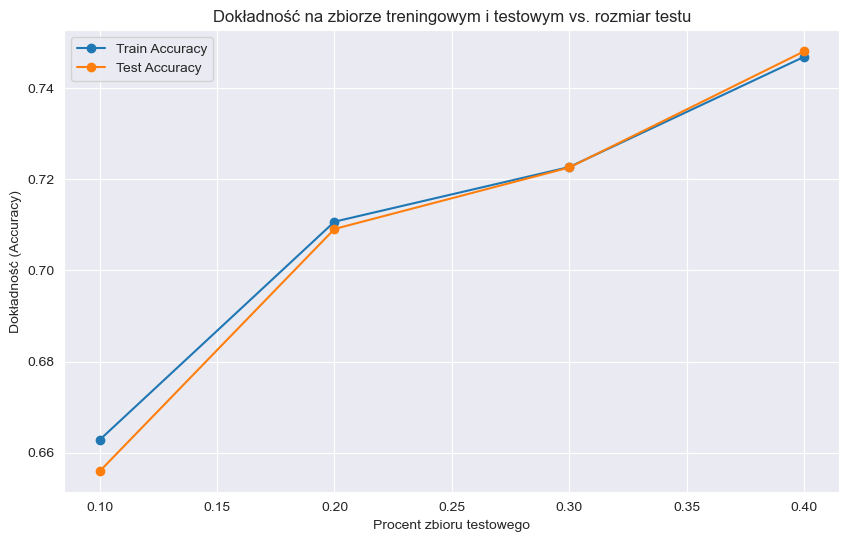

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_test_df['test_size'], train_test_df['avg_train_accuracy'], label='Train Accuracy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_test_accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Procent zbioru testowego')
plt.ylabel('Dokładność (Accuracy)')
plt.title('Dokładność na zbiorze treningowym i testowym vs. rozmiar testu')
plt.legend()
plt.grid(True)
plt.show()


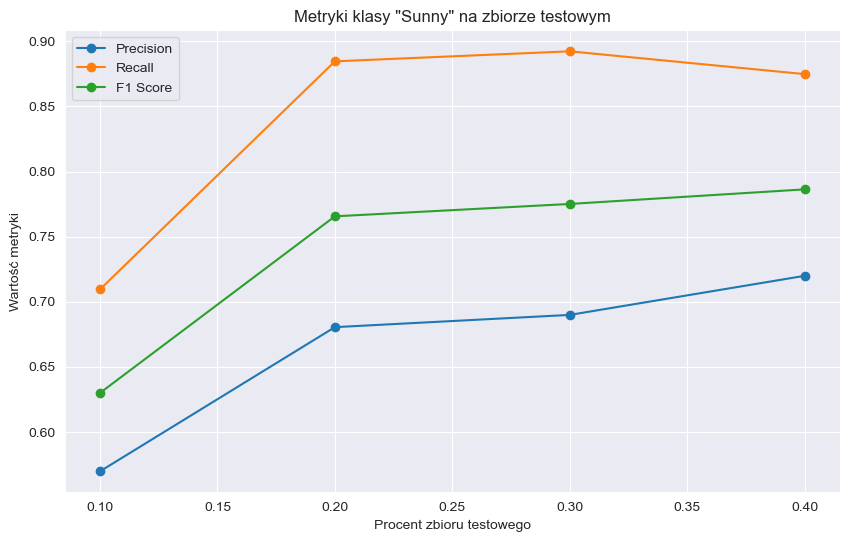

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_test_df['test_size'], train_test_df['avg_precision_test_Sunny'], label='Precision', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_recall_test_Sunny'], label='Recall', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_f1_test_Sunny'], label='F1 Score', marker='o')
plt.xlabel('Procent zbioru testowego')
plt.ylabel('Wartość metryki')
plt.title('Metryki klasy "Sunny" na zbiorze testowym')
plt.legend()
plt.grid(True)
plt.show()


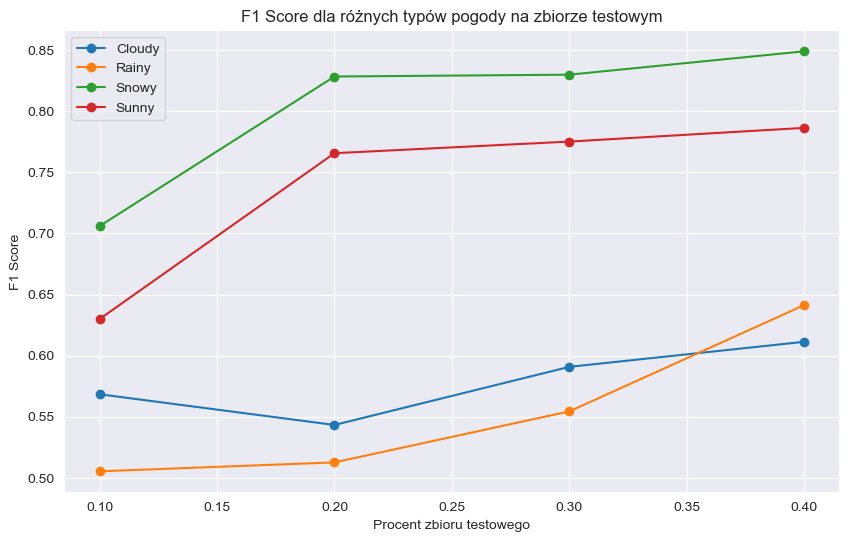

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_test_df['test_size'], train_test_df['avg_f1_test_Cloudy'], label='Cloudy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_f1_test_Rainy'], label='Rainy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_f1_test_Snowy'], label='Snowy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_f1_test_Sunny'], label='Sunny', marker='o')
plt.xlabel('Procent zbioru testowego')
plt.ylabel('F1 Score')
plt.title('F1 Score dla różnych typów pogody na zbiorze testowym')
plt.legend()
plt.grid(True)
plt.show()


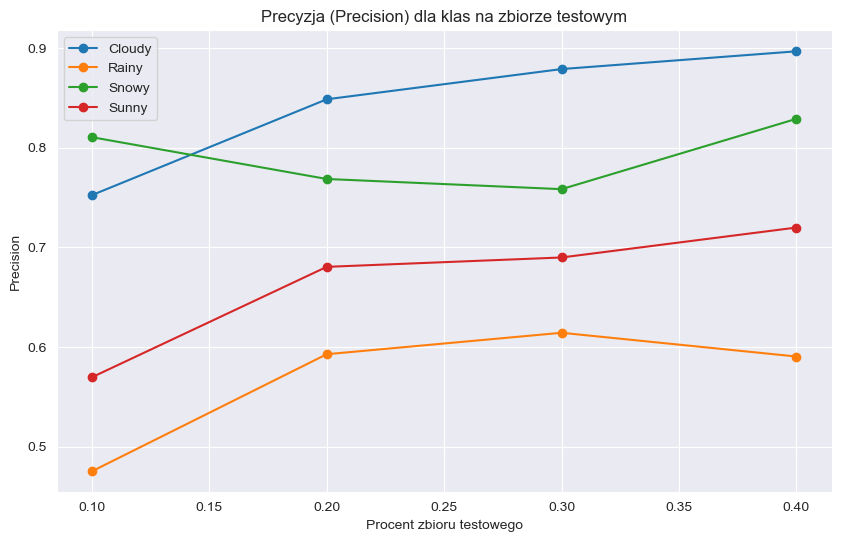

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_test_df['test_size'], train_test_df['avg_precision_test_Cloudy'], label='Cloudy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_precision_test_Rainy'], label='Rainy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_precision_test_Snowy'], label='Snowy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_precision_test_Sunny'], label='Sunny', marker='o')
plt.xlabel('Procent zbioru testowego')
plt.ylabel('Precision')
plt.title('Precyzja (Precision) dla klas na zbiorze testowym')
plt.legend()
plt.grid(True)
plt.show()


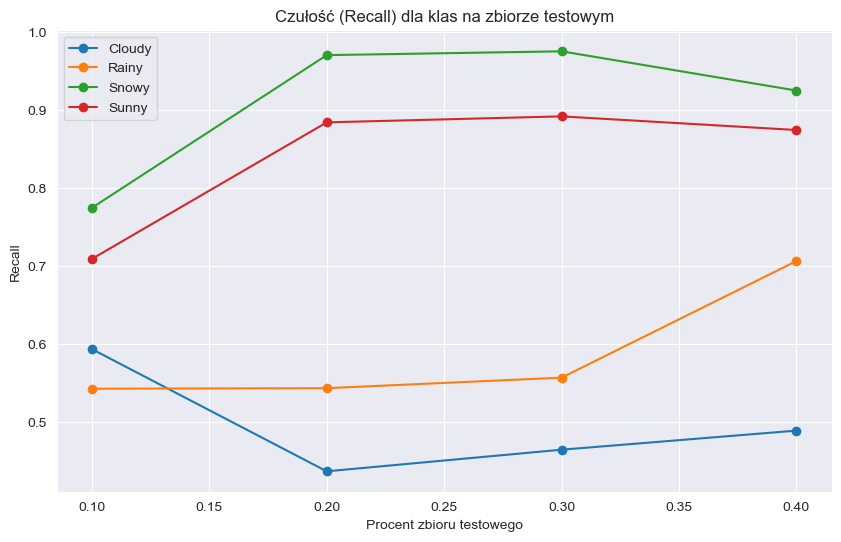

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_test_df['test_size'], train_test_df['avg_recall_test_Cloudy'], label='Cloudy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_recall_test_Rainy'], label='Rainy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_recall_test_Snowy'], label='Snowy', marker='o')
plt.plot(train_test_df['test_size'], train_test_df['avg_recall_test_Sunny'], label='Sunny', marker='o')
plt.xlabel('Procent zbioru testowego')
plt.ylabel('Recall')
plt.title('Czułość (Recall) dla klas na zbiorze testowym')
plt.legend()
plt.grid(True)
plt.show()


Najlepszy podział pod względem dokładności

In [23]:
best_idx = train_test_df['avg_test_accuracy'].idxmax()

best_test_size = train_test_df.loc[best_idx, 'test_size']
best_test_accuracy = train_test_df.loc[best_idx, 'avg_test_accuracy']
best_train_accuracy = train_test_df.loc[best_idx, 'avg_train_accuracy']

print(f"Najlepszy podział test/train: test_size = {best_test_size:.2f}")
print(f"Dokładność na zbiorze testowym: {best_test_accuracy:.4f}")
print(f"Dokładność na zbiorze treningowym: {best_train_accuracy:.4f}")


Najlepszy podział test/train: test_size = 0.40
Dokładność na zbiorze testowym: 0.7481
Dokładność na zbiorze treningowym: 0.7469


## Wnioski

- Najlepsza dokładność na zbiorze testowym została osiągnięta przy podziale test/train = 40/60
- Przy tym podziale model uzyskał dokładność na zbiorze testowym równą 0.7481 oraz na zbiorze treningowym 0.7469
- Warto wybrać kompromisowy podział, który maksymalizuje dokładność na zbiorze testowym i pozwala na odpowiednie trenowanie modelu.

## Analiza wpływu liczby neuronów w warstwie ukrytej na działanie sieci


Pobranie zapisanych wartości z pliku CSV (`porownanie_neuronow_klasyfikacja.csv`). <br>
Plik z kodem: `neurony_klasyfikacja.py`



### Opis problemu i podjętych kroków


Celem tej analizy było zbadanie wpływu liczby neuronów w warstwie ukrytej na jakość działania sieci neuronowej w zadaniu klasyfikacji.  
Sieć była trenowana wielokrotnie dla różnych wartości liczby neuronów.  
Następnie analizowano wartości metryk takich jak Accuracy, Precision, Recall oraz F1 Score – osobno dla zbioru treningowego i testowego.  
Dane zapisano do pliku `porownanie_neuronow_klasyfikacja.csv`, a następnie wczytano i przeanalizowano w Jupyter Notebook.

In [24]:
plik = 'klasyfikacja/porownanie_neuronow_klasyfikacja.csv'
neurony_df = pd.read_csv(plik)
neurony_df = neurony_df.round(4)
neurony_df.head()

,Neurony,avg_train_acc,avg_test_acc,precision_train_Cloudy,recall_train_Cloudy,f1_train_Cloudy,precision_test_Cloudy,recall_test_Cloudy,f1_test_Cloudy,precision_train_Rainy,...,f1_train_Snowy,precision_test_Snowy,recall_test_Snowy,f1_test_Snowy,precision_train_Sunny,recall_train_Sunny,f1_train_Sunny,precision_test_Sunny,recall_test_Sunny,f1_test_Sunny
0,5,0.8321,0.8284,0.8305,0.7791,0.8002,0.8236,0.7939,0.8048,0.7899,...,0.7993,0.8092,0.8080,0.7966,0.8857,0.9025,0.8938,0.8737,0.8903,0.8817
1,10,0.9148,0.9098,0.8980,0.8883,0.8930,0.8971,0.9010,0.8990,0.8729,...,0.9532,0.9250,0.9597,0.9419,0.9572,0.9026,0.9289,0.9436,0.8944,0.9182
2,20,0.9355,0.9285,0.9240,0.9116,0.9177,0.9156,0.9223,0.9189,0.9096,...,0.9682,0.9414,0.9760,0.9584,0.9552,0.9224,0.9385,0.9403,0.9036,0.9215
3,50,0.9451,0.9389,0.9311,0.9148,0.9228,0.9235,0.9304,0.9269,0.9226,...,0.9771,0.9542,0.9770,0.9655,0.9563,0.9376,0.9468,0.9466,0.9209,0.9336


In [25]:
neurony_df.describe()


,Neurony,avg_train_acc,avg_test_acc,precision_train_Cloudy,recall_train_Cloudy,f1_train_Cloudy,precision_test_Cloudy,recall_test_Cloudy,f1_test_Cloudy,precision_train_Rainy,...,f1_train_Snowy,precision_test_Snowy,recall_test_Snowy,f1_test_Snowy,precision_train_Sunny,recall_train_Sunny,f1_train_Sunny,precision_test_Sunny,recall_test_Sunny,f1_test_Sunny
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,21.250000,0.906875,0.901400,0.895900,0.873450,0.883425,0.889950,0.886900,0.887400,0.87375,...,0.924450,0.907450,0.930175,0.915600,0.938600,0.916275,0.927000,0.926050,0.902300,0.913750
std,20.155644,0.051428,0.050134,0.045863,0.063999,0.056989,0.045596,0.063228,0.056302,0.05973,...,0.084014,0.066581,0.081835,0.079947,0.035276,0.017020,0.023311,0.034995,0.013590,0.022369
min,5.000000,0.832100,0.828400,0.830500,0.779100,0.800200,0.823600,0.793900,0.804800,0.78990,...,0.799300,0.809200,0.808000,0.796600,0.885700,0.902500,0.893800,0.873700,0.890300,0.881700
25%,8.750000,0.894125,0.889450,0.881125,0.861000,0.869800,0.878725,0.874225,0.875450,0.85215,...,0.914725,0.896050,0.921775,0.905575,0.937825,0.902575,0.920125,0.923650,0.893375,0.909075
50%,15.000000,0.925150,0.919150,0.911000,0.899950,0.905350,0.906350,0.911650,0.908950,0.89125,...,0.960700,0.933200,0.967850,0.950150,0.955750,0.912500,0.933700,0.941950,0.899000,0.919850
75%,27.500000,0.937900,0.931100,0.925775,0.912400,0.918975,0.917575,0.924325,0.920900,0.91285,...,0.970425,0.944600,0.976250,0.960175,0.956525,0.926200,0.940575,0.944350,0.907925,0.924525
max,50.000000,0.945100,0.938900,0.931100,0.914800,0.922800,0.923500,0.930400,0.926900,0.92260,...,0.977100,0.954200,0.977000,0.965500,0.957200,0.937600,0.946800,0.946600,0.920900,0.933600


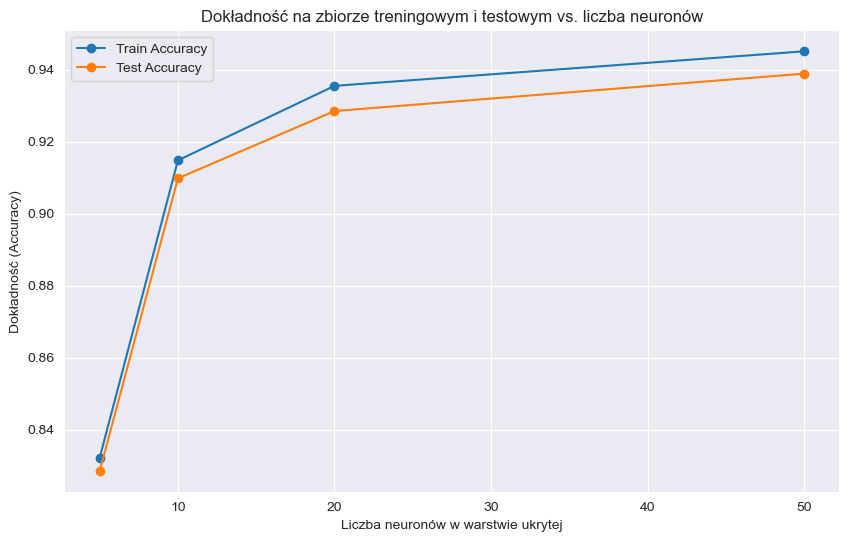

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(neurony_df['Neurony'], neurony_df['avg_train_acc'], label='Train Accuracy', marker='o')
plt.plot(neurony_df['Neurony'], neurony_df['avg_test_acc'], label='Test Accuracy', marker='o')
plt.xlabel('Liczba neuronów w warstwie ukrytej')
plt.ylabel('Dokładność (Accuracy)')
plt.title('Dokładność na zbiorze treningowym i testowym vs. liczba neuronów')
plt.legend()
plt.grid(True)
plt.show()


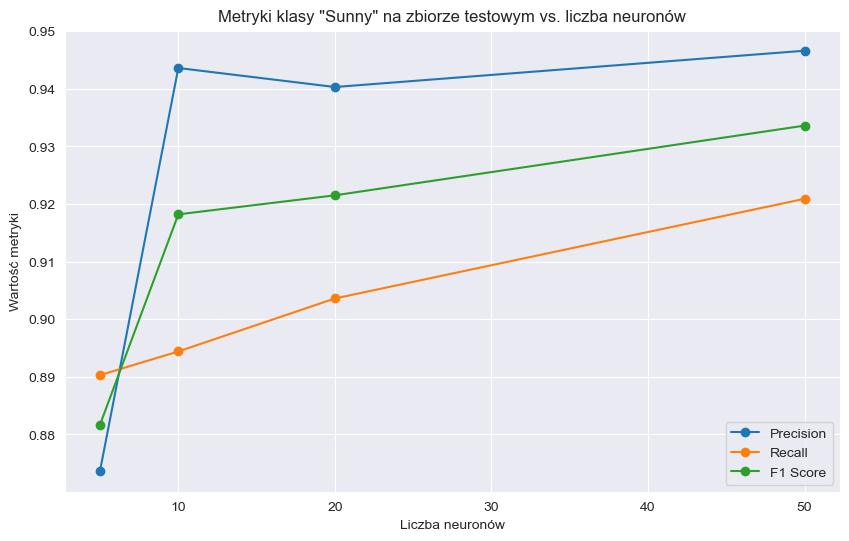

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(neurony_df['Neurony'], neurony_df['precision_test_Sunny'], label='Precision', marker='o')
plt.plot(neurony_df['Neurony'], neurony_df['recall_test_Sunny'], label='Recall', marker='o')
plt.plot(neurony_df['Neurony'], neurony_df['f1_test_Sunny'], label='F1 Score', marker='o')
plt.xlabel('Liczba neuronów')
plt.ylabel('Wartość metryki')
plt.title('Metryki klasy "Sunny" na zbiorze testowym vs. liczba neuronów')
plt.legend()
plt.grid(True)
plt.show()


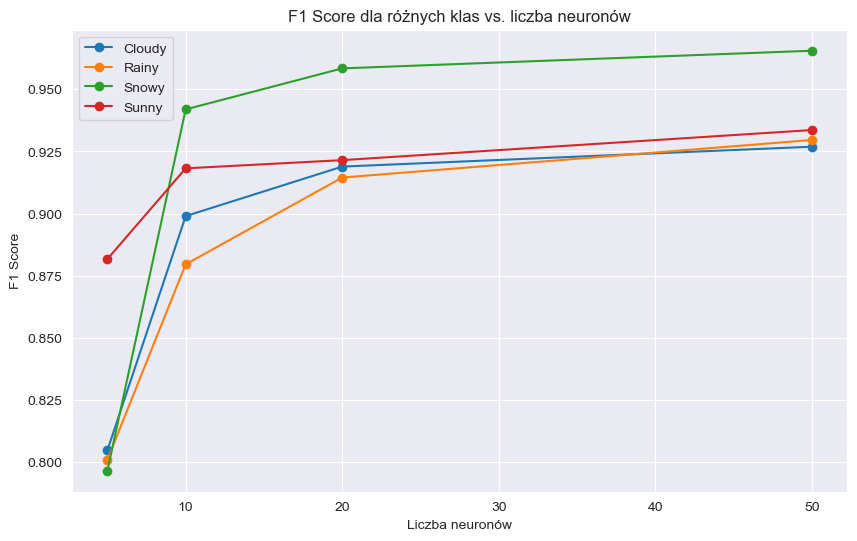

In [28]:
plt.figure(figsize=(10, 6))
for label in ['Cloudy', 'Rainy', 'Snowy', 'Sunny']:
    plt.plot(neurony_df['Neurony'], neurony_df[f'f1_test_{label}'], label=label, marker='o')
plt.xlabel('Liczba neuronów')
plt.ylabel('F1 Score')
plt.title('F1 Score dla różnych klas vs. liczba neuronów')
plt.legend()
plt.grid(True)
plt.show()


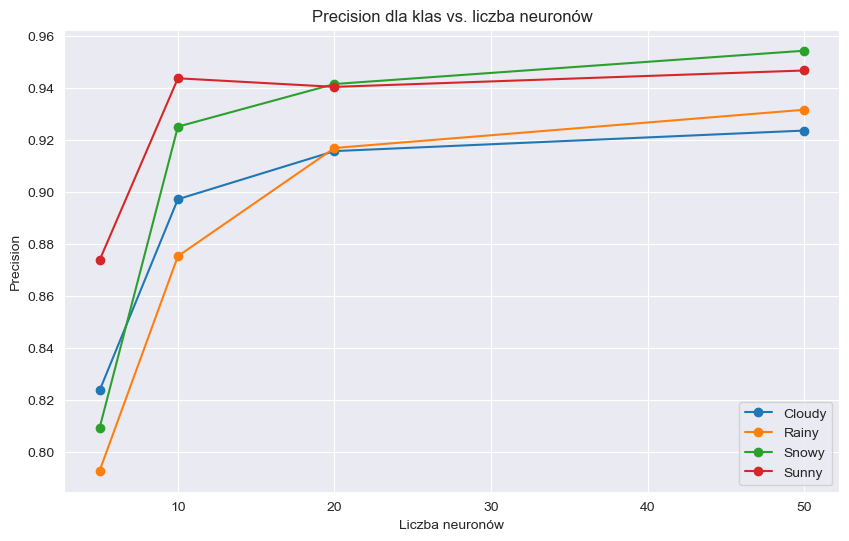

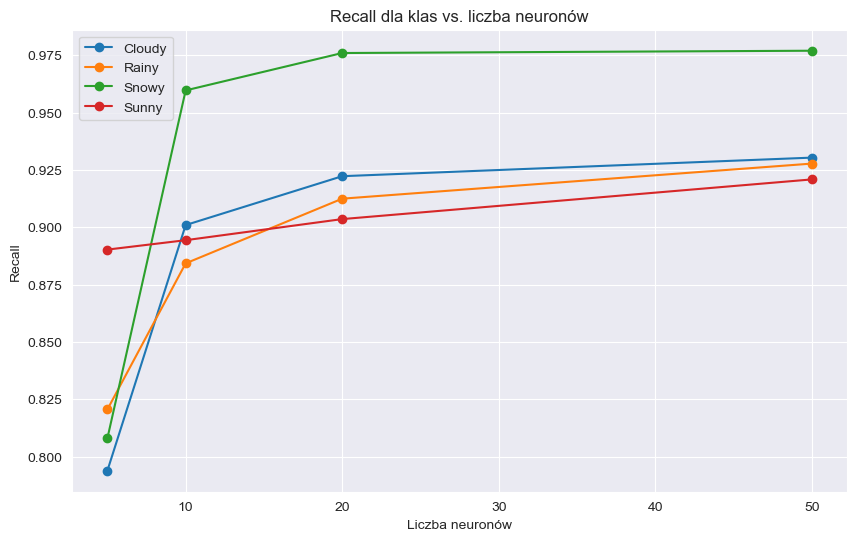

In [29]:
plt.figure(figsize=(10, 6))
for label in ['Cloudy', 'Rainy', 'Snowy', 'Sunny']:
    plt.plot(neurony_df['Neurony'], neurony_df[f'precision_test_{label}'], label=label, marker='o')
plt.xlabel('Liczba neuronów')
plt.ylabel('Precision')
plt.title('Precision dla klas vs. liczba neuronów')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for label in ['Cloudy', 'Rainy', 'Snowy', 'Sunny']:
    plt.plot(neurony_df['Neurony'], neurony_df[f'recall_test_{label}'], label=label, marker='o')
plt.xlabel('Liczba neuronów')
plt.ylabel('Recall')
plt.title('Recall dla klas vs. liczba neuronów')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
best_idx = neurony_df['avg_test_acc'].idxmax()
best_neurons = neurony_df.loc[best_idx, 'Neurony']
best_test_accuracy = neurony_df.loc[best_idx, 'avg_test_acc']
best_train_accuracy = neurony_df.loc[best_idx, 'avg_train_acc']

print(f"Najlepsza liczba neuronów: {best_neurons}")
print(f"Dokładność na zbiorze testowym: {best_test_accuracy:.4f}")
print(f"Dokładność na zbiorze treningowym: {best_train_accuracy:.4f}")


Najlepsza liczba neuronów: 50
Dokładność na zbiorze testowym: 0.9389
Dokładność na zbiorze treningowym: 0.9451


## Wnioski



- Najlepsza dokładność na zbiorze testowym została osiągnięta przy liczbie neuronów: 50
- Dokładność testowa dla tej konfiguracji wyniosła 0.9389, a treningowa 0.9451
- Zbyt mała liczba neuronów skutkuje niedouczeniem modelu, natomiast zbyt duża może prowadzić do przeuczenia

# Analiza wpływu rodzaju funkcji aktywacji na działanie sieci

Pobranie zapisanych wartości z excela (`porownanie_srednie.csv`). <br>
Plik z kodem `klasyfikacja_funkcje_aktywacji.py`

### Opis problemu

W celu analizy działania sieci neuronowej zdecydowałem się zbadać wpływ funkcji aktywacji na skuteczność modelu. Sieć była trenowana przy stałym podziale danych

Analiza została przeprowadza w pliku `klasyfikacja_funkcje_aktywacji.py`. Następnie rezultaty zapisane w pliku `porownanie_srednie.csv` i odczytane w Jupyter. Zostały zwizualizowane i przeanalizowane. Na samym końcu wyciągnąłem wnioski.

In [31]:
df_funkcje_aktywacji = pd.read_csv('klasyfikacja/porownanie_srednie.csv')
df_funkcje_aktywacji = df_funkcje_aktywacji.drop(['repeat', 'test_size'], axis=1)
df_funkcje_aktywacji


,activation,avg_train_accuracy,avg_test_accuracy,avg_precision_train_0,avg_recall_train_0,avg_f1_train_0,avg_precision_test_0,avg_recall_test_0,avg_f1_test_0,avg_precision_train_1,...,avg_f1_train_2,avg_precision_test_2,avg_recall_test_2,avg_f1_test_2,avg_precision_train_3,avg_recall_train_3,avg_f1_train_3,avg_precision_test_3,avg_recall_test_3,avg_f1_test_3
0,linear,0.892792,0.891976,0.870266,0.799747,0.832902,0.870071,0.795608,0.830472,0.844466,...,0.984696,0.981615,0.981217,0.981403,0.902007,0.856803,0.873260,0.899281,0.858404,0.873480
1,relu,0.709927,0.705781,0.865348,0.355490,0.459559,0.860888,0.347297,0.444862,0.701242,...,0.850024,0.851188,0.892870,0.843752,0.664241,0.881122,0.753416,0.662499,0.882513,0.752666
2,sigmoid,0.686448,0.682744,0.740924,0.629730,0.585134,0.736586,0.625338,0.585095,0.658252,...,0.718716,0.704993,0.725913,0.713434,0.477051,0.500595,0.464880,0.479461,0.497114,0.463382
3,tanh,0.690613,0.684383,0.717001,0.480743,0.480648,0.780911,0.473986,0.478063,0.640846,...,0.723273,0.732009,0.704000,0.712332,0.554645,0.667177,0.595543,0.557016,0.662479,0.595031


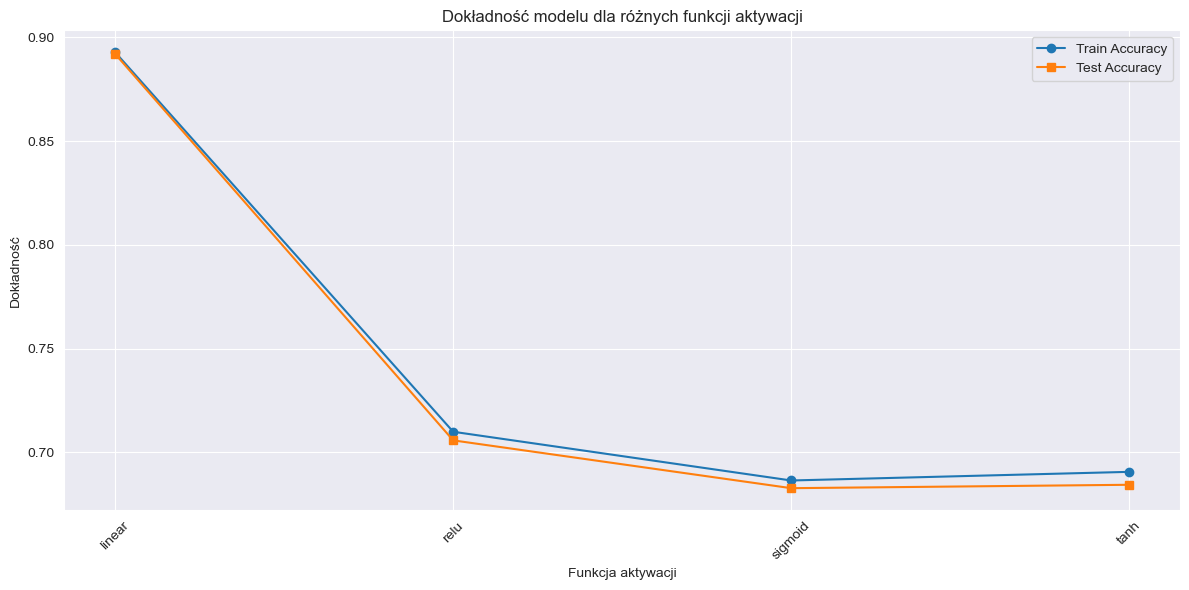

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_funkcje_aktywacji['activation'], df_funkcje_aktywacji['avg_train_accuracy'], marker='o',
         label='Train Accuracy')
plt.plot(df_funkcje_aktywacji['activation'], df_funkcje_aktywacji['avg_test_accuracy'], marker='s',
         label='Test Accuracy')
plt.title('Dokładność modelu dla różnych funkcji aktywacji')
plt.xlabel('Funkcja aktywacji')
plt.ylabel('Dokładność')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

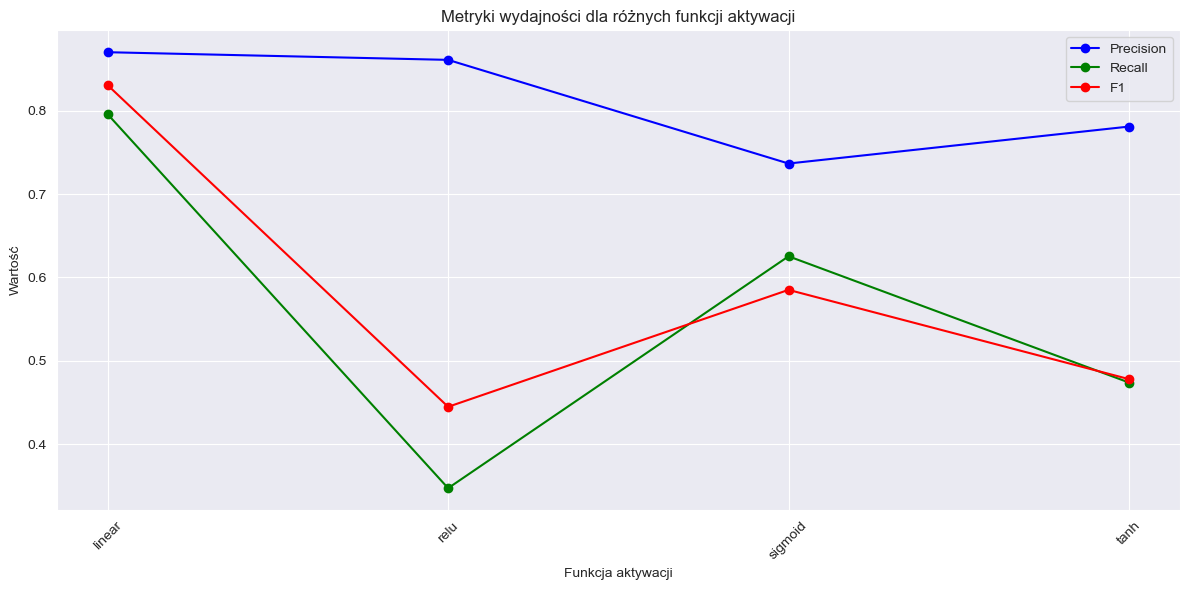

In [33]:
metrics = ['precision', 'recall', 'f1']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(12, 6))
for metric, color in zip(metrics, colors):
    column_name = f'avg_{metric}_test_0'
    plt.plot(df_funkcje_aktywacji['activation'], df_funkcje_aktywacji[column_name],
             marker='o', label=metric.capitalize(), color=color)

plt.title('Metryki wydajności dla różnych funkcji aktywacji')
plt.xlabel('Funkcja aktywacji')
plt.ylabel('Wartość')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

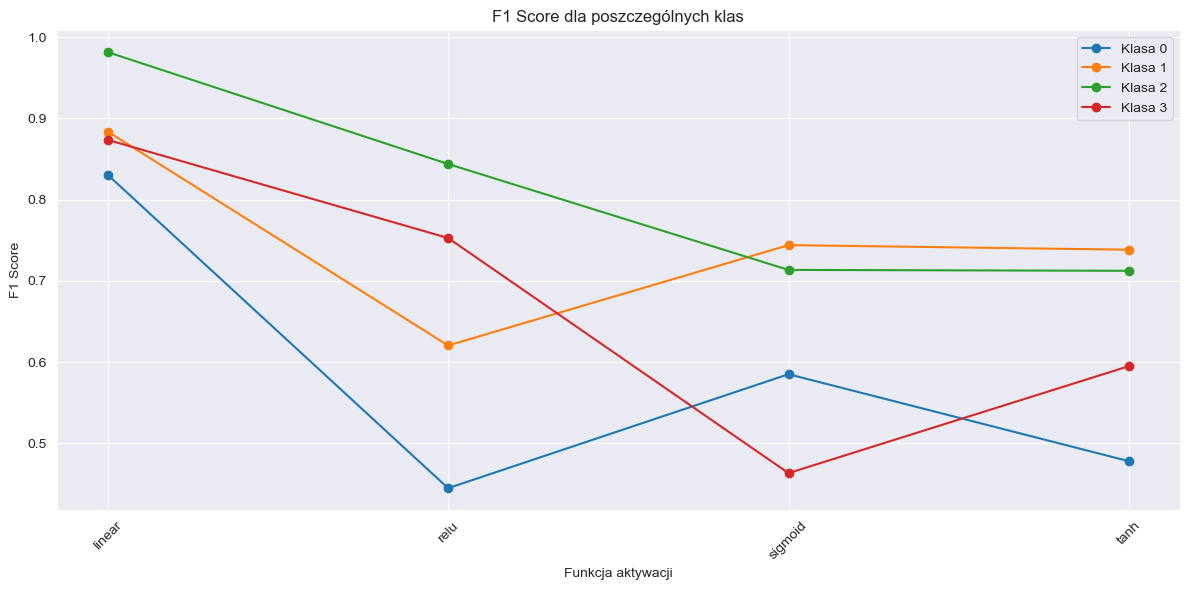

In [34]:
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(df_funkcje_aktywacji['activation'],
             df_funkcje_aktywacji[f'avg_f1_test_{i}'],
             marker='o',
             label=f'Klasa {i}')

plt.title('F1 Score dla poszczególnych klas')
plt.xlabel('Funkcja aktywacji')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
best_activation = df_funkcje_aktywacji.loc[df_funkcje_aktywacji['avg_test_accuracy'].idxmax()]
print(f"Najlepsza funkcja aktywacji: {best_activation['activation']}")
print(f"Dokładność na zbiorze testowym: {best_activation['avg_test_accuracy']:.4f}")
print(f"Dokładność na zbiorze treningowym: {best_activation['avg_train_accuracy']:.4f}")


Najlepsza funkcja aktywacji: linear
Dokładność na zbiorze testowym: 0.8920
Dokładność na zbiorze treningowym: 0.8928


Wnioski : 
- Funkcja linear osiągnęła najwyższą dokładność (~89%) zarówno na zbiorze treningowym, jak i testowym.
- Wszystkie funkcje aktywacji pokazały zbliżone wyniki na zbiorach treningowym i testowym, co wskazuje na brak przeuczenia modelu.

- Funkcja aktywacji linear zapewnia najwyższe wartości wszystkich trzech metryk: precision, recall i F1, co wskazuje na jej przewagę w tym zadaniu.

- Funkcja linear znacząco przewyższała pozostałe funkcje we wszystkich klasach, z najwyższym F1 Score dla klasy 2.

# Analiza wpływu metody uczenia na działanie sieci

Pobranie zapisanych wartości z excela (`analiza_metod_klas2.csv`). <br>
Plik z kodem `metody_klasyfikacja.py`

### Opis problemu

W celu analizy działania sieci neuronowej zdecydowano się zbadać wpływ metody uczenia na skuteczność modelu. Sieć była trenowana przy stałym podziale danych treningowych i testowych.

Wyniki zostały zwizualizowane i poddane analizie. Na końcu sformułowano odpowiednie wnioski.



In [36]:
df_metoda = pd.read_csv('klasyfikacja/analiza_metod_klas2.csv')
df_metoda

,learning_method,avg_train_accuracy,avg_test_accuracy,avg_precision_train_Cloudy,avg_recall_train_Cloudy,avg_f1_train_Cloudy,avg_precision_test_Cloudy,avg_recall_test_Cloudy,avg_f1_test_Cloudy,avg_precision_train_Rainy,...,avg_f1_train_Snowy,avg_precision_test_Snowy,avg_recall_test_Snowy,avg_f1_test_Snowy,avg_precision_train_Sunny,avg_recall_train_Sunny,avg_f1_train_Sunny,avg_precision_test_Sunny,avg_recall_test_Sunny,avg_f1_test_Sunny
0,Batch Gradient Descent,0.910445,0.903796,0.866339,0.892314,0.879135,0.879736,0.902027,0.890742,0.886324,...,0.963974,0.927152,0.973913,0.949958,0.947246,0.862670,0.902982,0.940410,0.857385,0.896980
1,Mini-Batch Gradient Descent,0.976586,0.966350,0.962384,0.961571,0.961977,0.949580,0.954392,0.951980,0.961050,...,0.991739,0.982578,0.980870,0.981723,0.991368,0.976616,0.983937,0.967466,0.959253,0.963342
2,AdaGrad,0.966228,0.960742,0.946947,0.949747,0.948345,0.934102,0.957770,0.945788,0.951092,...,0.987622,0.986014,0.980870,0.983435,0.980853,0.958333,0.969462,0.966899,0.942275,0.954428
3,Momentum,0.996116,0.965056,0.994083,0.993243,0.993663,0.943144,0.952703,0.947899,0.992028,...,0.999565,0.977509,0.982609,0.980052,0.998720,0.995323,0.997019,0.975945,0.964346,0.970111


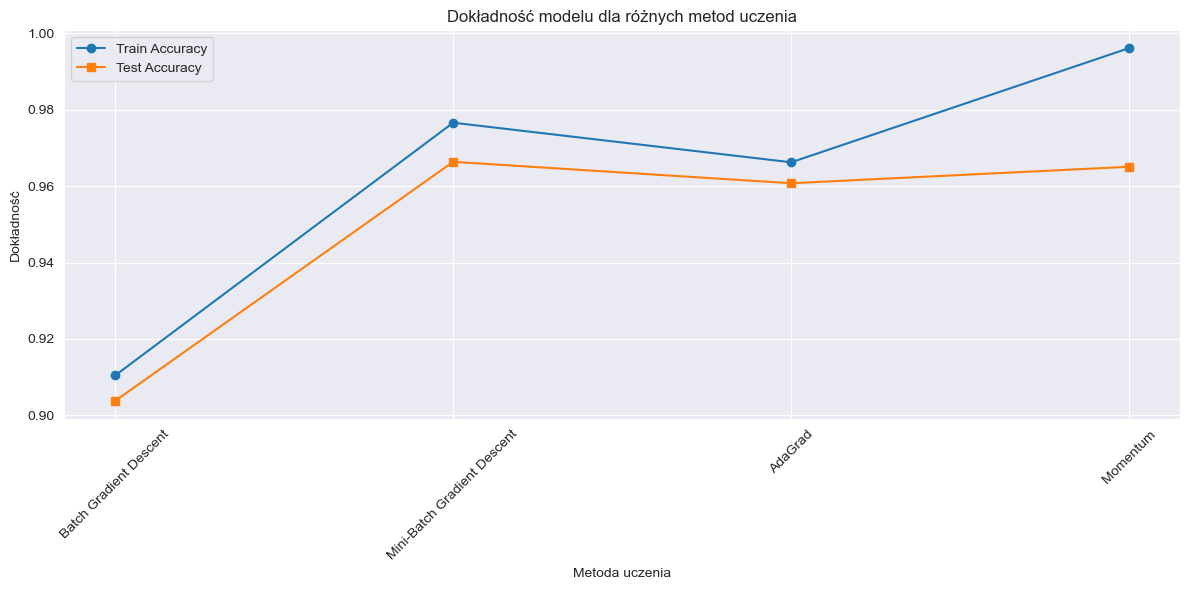

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df_metoda['learning_method'], df_metoda['avg_train_accuracy'], marker='o',
         label='Train Accuracy')
plt.plot(df_metoda['learning_method'], df_metoda['avg_test_accuracy'], marker='s',
         label='Test Accuracy')
plt.title('Dokładność modelu dla różnych metod uczenia')
plt.xlabel('Metoda uczenia')
plt.ylabel('Dokładność')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

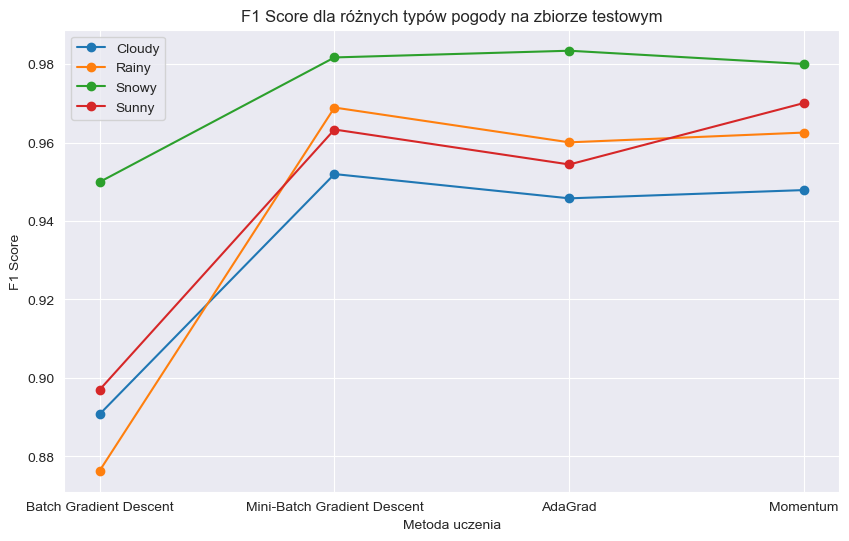

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(df_metoda['learning_method'], df_metoda['avg_f1_test_Cloudy'], label='Cloudy', marker='o')
plt.plot(df_metoda['learning_method'], df_metoda['avg_f1_test_Rainy'], label='Rainy', marker='o')
plt.plot(df_metoda['learning_method'], df_metoda['avg_f1_test_Snowy'], label='Snowy', marker='o')
plt.plot(df_metoda['learning_method'], df_metoda['avg_f1_test_Sunny'], label='Sunny', marker='o')
plt.xlabel('Metoda uczenia')
plt.ylabel('F1 Score')
plt.title('F1 Score dla różnych typów pogody na zbiorze testowym')
plt.legend()
plt.grid(True)
plt.show()

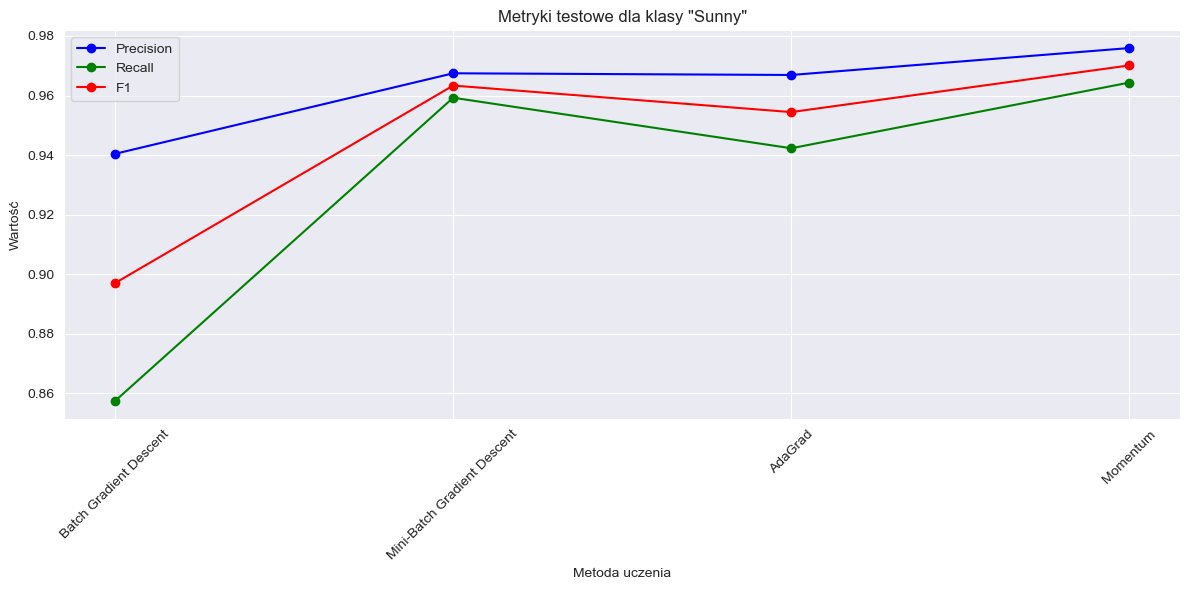

In [39]:
metrics = ['precision', 'recall', 'f1']
colors = ['blue', 'green', 'red']
weather = 'Sunny'  

plt.figure(figsize=(12, 6))
for metric, color in zip(metrics, colors):
    column_name = f'avg_{metric}_test_{weather}'
    plt.plot(df_metoda['learning_method'], df_metoda[column_name],
             marker='o', label=metric.capitalize(), color=color)

plt.title(f'Metryki testowe dla klasy "{weather}"')
plt.xlabel('Metoda uczenia')
plt.ylabel('Wartość')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
best_method = df_metoda.loc[df_metoda['avg_test_accuracy'].idxmax()]
print(f"Najlepsza funkcja aktywacji: {best_method['learning_method']}")
print(f"Dokładność na zbiorze testowym: {best_method['avg_test_accuracy']:.4f}")
print(f"Dokładność na zbiorze treningowym: {best_method['avg_train_accuracy']:.4f}")

Najlepsza funkcja aktywacji: Mini-Batch Gradient Descent
Dokładność na zbiorze testowym: 0.9664
Dokładność na zbiorze treningowym: 0.9766


### Wnioski:

 - Najwyższą dokładność na zbiorze treningowym osiągnęła metoda Momentum, z kolei na testowym najwyższą dokładność osiągnęła metoda Mini-Batch Gradient Descent

 - Funkcja Momentum zapewnia najwyższe wartości wszystkich trzech metryk: precision, recall i F1 dla klasy Sunny

 - Najwyższe wyniki F1 każda z klas za wyjątkiem Snowy osiąga dla metody Momentum

 - Najgorzej w każdym badanym aspekcie wypada metoda Batch Gradient Descent